In [7]:
!pip -q install medmnist torch torchvision torchaudio scikit-learn matplotlib tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 10.4 MB/s eta 0:00:00


In [8]:
import os, random, numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    roc_auc_score, confusion_matrix, roc_curve
)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cpu")  # keep CPU as you requested
print("Device:", device)


Device: cpu


In [9]:
import medmnist
from medmnist import INFO
from medmnist.dataset import PneumoniaMNIST

info = INFO["pneumoniamnist"]
print("Dataset:", info["description"])
print("Labels:", info["label"])

# Normalize: common safe default for grayscale
transform_train = T.Compose([
    T.ToTensor(),
    T.RandomHorizontalFlip(p=0.5),
    T.Normalize(mean=[0.5], std=[0.5]),
])

transform_eval = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5]),
])

train_ds = PneumoniaMNIST(split="train", transform=transform_train, download=True)
val_ds   = PneumoniaMNIST(split="val", transform=transform_eval, download=True)
test_ds  = PneumoniaMNIST(split="test", transform=transform_eval, download=True)

print("Sizes:", len(train_ds), len(val_ds), len(test_ds))
x, y = train_ds[0]
print("Sample:", x.shape, "Label:", y)


Dataset: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
Labels: {'0': 'normal', '1': 'pneumonia'}


100%|██████████| 4.17M/4.17M [00:01<00:00, 3.14MB/s]


Sizes: 4708 524 624
Sample: torch.Size([1, 28, 28]) Label: [1]


In [10]:
BATCH_SIZE = 128

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("Loaders ready.")


Loaders ready.


In [11]:
# Extract training labels to compute imbalance
y_train = np.array([int(train_ds[i][1]) for i in range(len(train_ds))])
n_pos = (y_train == 1).sum()
n_neg = (y_train == 0).sum()

pos_weight = torch.tensor([n_neg / n_pos], dtype=torch.float32)  # weight for positive class
print("Train positives:", n_pos, "negatives:", n_neg, "pos_weight:", float(pos_weight))


/tmp/ipython-input-2896098952.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_train = np.array([int(train_ds[i][1]) for i in range(len(train_ds))])


Train positives: 3494 negatives: 1214 pos_weight: 0.3474527895450592


In [12]:
class BetterCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 14x14

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 7x7

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)),

            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)  # binary logit
        )

    def forward(self, x):
        return self.net(x).squeeze(1)

model = BetterCNN().to(device)
print(model)


BetterCNN(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): AdaptiveAvgPool2d(output_size=(1, 1))
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Dropout(p=0.3, inplace=False)
    (14): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [13]:
def predict_probs(model, loader):
    model.eval()
    probs_list, y_list = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            logits = model(x)
            probs = torch.sigmoid(logits).cpu().numpy()
            probs_list.append(probs)
            y_list.append(y.numpy().reshape(-1))
    return np.concatenate(probs_list), np.concatenate(y_list)


In [14]:
def train_model(model, train_loader, val_loader, epochs=15, lr=1e-3, weight_decay=1e-4):
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Removed verbose argument (compatibility fix)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="max", factor=0.5, patience=2
    )

    history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
    best_val_acc = -1
    best_state = None

    for epoch in range(1, epochs+1):

        # ---- TRAIN ----
        model.train()
        tr_loss = 0.0
        tr_probs, tr_y = [], []

        for x, y in train_loader:
            x = x.to(device)
            y = y.float().to(device).view(-1)

            logits = model(x)
            loss = criterion(logits, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            tr_loss += loss.item() * x.size(0)
            tr_probs.append(torch.sigmoid(logits).detach().cpu().numpy())
            tr_y.append(y.detach().cpu().numpy())

        tr_probs = np.concatenate(tr_probs)
        tr_y = np.concatenate(tr_y)
        tr_pred = (tr_probs >= 0.5).astype(int)
        tr_acc = accuracy_score(tr_y, tr_pred)
        tr_loss = tr_loss / len(train_loader.dataset)

        # ---- VALIDATION ----
        model.eval()
        va_loss = 0.0
        va_probs, va_y = [], []

        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(device)
                y = y.float().to(device).view(-1)

                logits = model(x)
                loss = criterion(logits, y)

                va_loss += loss.item() * x.size(0)
                va_probs.append(torch.sigmoid(logits).cpu().numpy())
                va_y.append(y.cpu().numpy())

        va_probs = np.concatenate(va_probs)
        va_y = np.concatenate(va_y)
        va_pred = (va_probs >= 0.5).astype(int)
        va_acc = accuracy_score(va_y, va_pred)
        va_loss = va_loss / len(val_loader.dataset)

        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(va_loss)
        history["val_acc"].append(va_acc)

        if va_acc > best_val_acc:
            best_val_acc = va_acc
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

        scheduler.step(va_acc)

        print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.3f} | "
              f"val loss {va_loss:.4f} acc {va_acc:.3f}")

    return history, best_state, best_val_acc


In [15]:
EPOCHS = 15
LR = 1e-3

history, best_state, best_val_acc = train_model(
    model, train_loader, val_loader, epochs=EPOCHS, lr=LR, weight_decay=1e-4
)

print("Best val acc:", best_val_acc)

os.makedirs("models", exist_ok=True)
torch.save(best_state, "models/task1_cnn_best.pt")
print("Saved: models/task1_cnn_best.pt")


Epoch 01 | train loss 0.1695 acc 0.841 | val loss 1.1449 acc 0.742
Epoch 02 | train loss 0.1100 acc 0.914 | val loss 0.1153 acc 0.887
Epoch 03 | train loss 0.0849 acc 0.934 | val loss 0.0809 acc 0.931
Epoch 04 | train loss 0.0717 acc 0.947 | val loss 0.0743 acc 0.954
Epoch 05 | train loss 0.0629 acc 0.948 | val loss 1.0095 acc 0.744
Epoch 06 | train loss 0.0676 acc 0.947 | val loss 0.0692 acc 0.962
Epoch 07 | train loss 0.0540 acc 0.958 | val loss 0.0790 acc 0.918
Epoch 08 | train loss 0.0565 acc 0.959 | val loss 0.0750 acc 0.920
Epoch 09 | train loss 0.0461 acc 0.966 | val loss 0.1560 acc 0.830
Epoch 10 | train loss 0.0419 acc 0.968 | val loss 0.0909 acc 0.895
Epoch 11 | train loss 0.0383 acc 0.969 | val loss 0.0543 acc 0.948
Epoch 12 | train loss 0.0396 acc 0.972 | val loss 0.1249 acc 0.870
Epoch 13 | train loss 0.0355 acc 0.973 | val loss 0.0356 acc 0.983
Epoch 14 | train loss 0.0318 acc 0.978 | val loss 0.0414 acc 0.962
Epoch 15 | train loss 0.0346 acc 0.973 | val loss 0.0716 acc 0

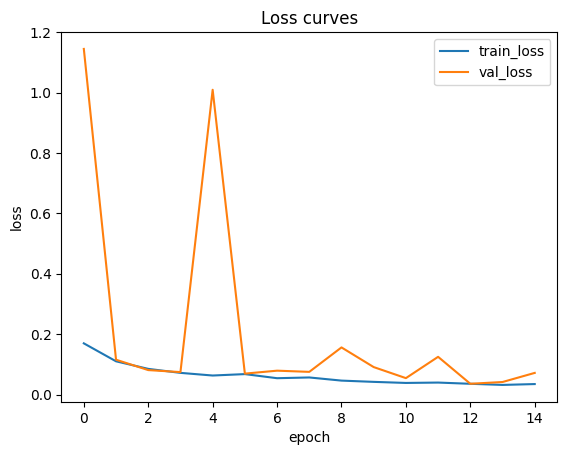

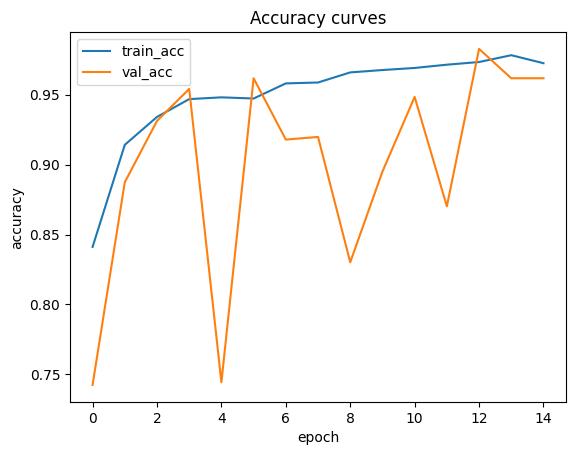

In [16]:
plt.figure()
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.title("Loss curves")
plt.show()

plt.figure()
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["val_acc"], label="val_acc")
plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.legend(); plt.title("Accuracy curves")
plt.show()


In [17]:
# Load best weights into model
model.load_state_dict(torch.load("models/task1_cnn_best.pt", map_location="cpu"))
model.eval()

val_probs, val_y = predict_probs(model, val_loader)

best_t, best_f1 = 0.5, -1
for t in np.linspace(0.1, 0.9, 81):
    pred = (val_probs >= t).astype(int)
    _, _, f1, _ = precision_recall_fscore_support(val_y, pred, average="binary", zero_division=0)
    if f1 > best_f1:
        best_f1 = f1
        best_t = float(t)

print("Best threshold (val):", best_t)
print("Best val F1:", best_f1)


Best threshold (val): 0.51
Best val F1: 0.9896373056994818


In [18]:
test_probs, test_y = predict_probs(model, test_loader)
test_pred = (test_probs >= best_t).astype(int)

acc = accuracy_score(test_y, test_pred)
prec, rec, f1, _ = precision_recall_fscore_support(test_y, test_pred, average="binary", zero_division=0)
auc = roc_auc_score(test_y, test_probs)

cm = confusion_matrix(test_y, test_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp + 1e-9)

print(f"Threshold: {best_t}")
print(f"Test Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")
print(f"Specificity: {specificity:.4f}")
print("Confusion matrix:\n", cm)


Threshold: 0.51
Test Accuracy: 0.8718
Precision: 0.8370 | Recall: 0.9872 | F1: 0.9059 | AUC: 0.9608
Specificity: 0.6795
Confusion matrix:
 [[159  75]
 [  5 385]]


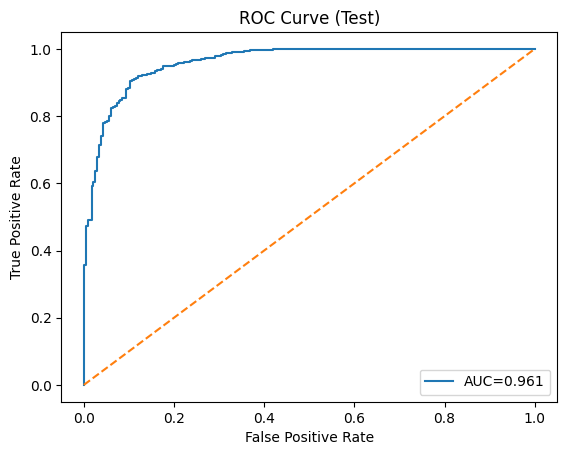

In [19]:
fpr, tpr, _ = roc_curve(test_y, test_probs)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test)")
plt.legend()
plt.show()


In [20]:
def predict_probs(model, loader):
    model.eval()
    probs_list, y_list = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            logits = model(x)
            probs = torch.sigmoid(logits).cpu().numpy()
            probs_list.append(probs)
            y_list.append(y.numpy().reshape(-1))
    return np.concatenate(probs_list), np.concatenate(y_list)

In [21]:
from sklearn.metrics import balanced_accuracy_score

# Get validation probabilities
val_probs, val_y = predict_probs(model, val_loader)

best_t_ba, best_ba = 0.5, -1
best_t_f1, best_f1 = 0.5, -1

for t in np.linspace(0.1, 0.9, 81):
    pred = (val_probs >= t).astype(int)

    ba = balanced_accuracy_score(val_y, pred)
    _, _, f1, _ = precision_recall_fscore_support(val_y, pred, average="binary", zero_division=0)

    if ba > best_ba:
        best_ba = float(ba)
        best_t_ba = float(t)

    if f1 > best_f1:
        best_f1 = float(f1)
        best_t_f1 = float(t)

print("Best threshold by Balanced Accuracy:", best_t_ba, "Balanced Acc:", best_ba)
print("Best threshold by F1:", best_t_f1, "F1:", best_f1)


Best threshold by Balanced Accuracy: 0.51 Balanced Acc: 0.9872988669903837
Best threshold by F1: 0.51 F1: 0.9896373056994818


In [23]:
def eval_with_threshold(t):
    test_probs, test_y = predict_probs(model, test_loader)
    pred = (test_probs >= t).astype(int)

    acc = accuracy_score(test_y, pred)
    prec, rec, f1, _ = precision_recall_fscore_support(test_y, pred, average="binary", zero_division=0)
    auc = roc_auc_score(test_y, test_probs)

    cm = confusion_matrix(test_y, pred)
    tn, fp, fn, tp = cm.ravel()
    spec = tn / (tn + fp + 1e-9)

    print("\n==============================")
    print("Threshold:", t)
    print(f"Test Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")
    print(f"Specificity: {spec:.4f}")
    print("Confusion matrix:\n", cm)
    print("==============================")

# Evaluate both
eval_with_threshold(best_t_f1)   # threshold optimized for F1
eval_with_threshold(best_t_ba)   # threshold optimized for balanced accuracy



Threshold: 0.51
Test Accuracy: 0.8718
Precision: 0.8370 | Recall: 0.9872 | F1: 0.9059 | AUC: 0.9608
Specificity: 0.6795
Confusion matrix:
 [[159  75]
 [  5 385]]

Threshold: 0.51
Test Accuracy: 0.8718
Precision: 0.8370 | Recall: 0.9872 | F1: 0.9059 | AUC: 0.9608
Specificity: 0.6795
Confusion matrix:
 [[159  75]
 [  5 385]]


In [24]:
Threshold = 0.51


In [25]:
# --- Choose your final threshold ---
FINAL_T = 0.51  # <-- keep this as locked

# We need access to raw test samples (without shuffling)
test_loader_vis = DataLoader(test_ds, batch_size=128, shuffle=False, num_workers=2)

# Get probs + labels
test_probs, test_y = predict_probs(model, test_loader_vis)
test_pred = (test_probs >= FINAL_T).astype(int)

# Find failure indices
fp_idx = np.where((test_y == 0) & (test_pred == 1))[0]  # false positives
fn_idx = np.where((test_y == 1) & (test_pred == 0))[0]  # false negatives
tp_idx = np.where((test_y == 1) & (test_pred == 1))[0]  # true positives
tn_idx = np.where((test_y == 0) & (test_pred == 0))[0]  # true negatives

print("Total test samples:", len(test_y))
print("False Positives (0->1):", len(fp_idx))
print("False Negatives (1->0):", len(fn_idx))
print("True Positives:", len(tp_idx))
print("True Negatives:", len(tn_idx))


Total test samples: 624
False Positives (0->1): 75
False Negatives (1->0): 5
True Positives: 385
True Negatives: 159


Showing False Positives (Normal predicted as Pneumonia):


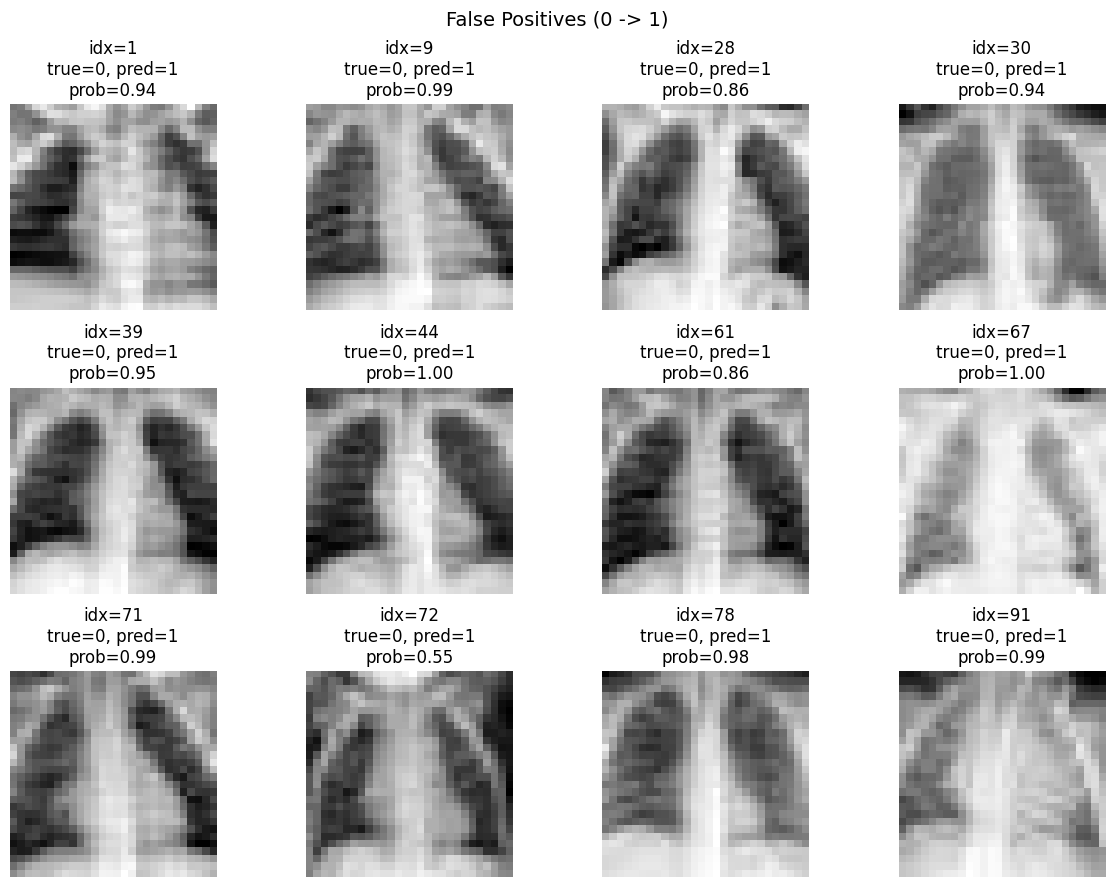


Showing False Negatives (Pneumonia predicted as Normal):


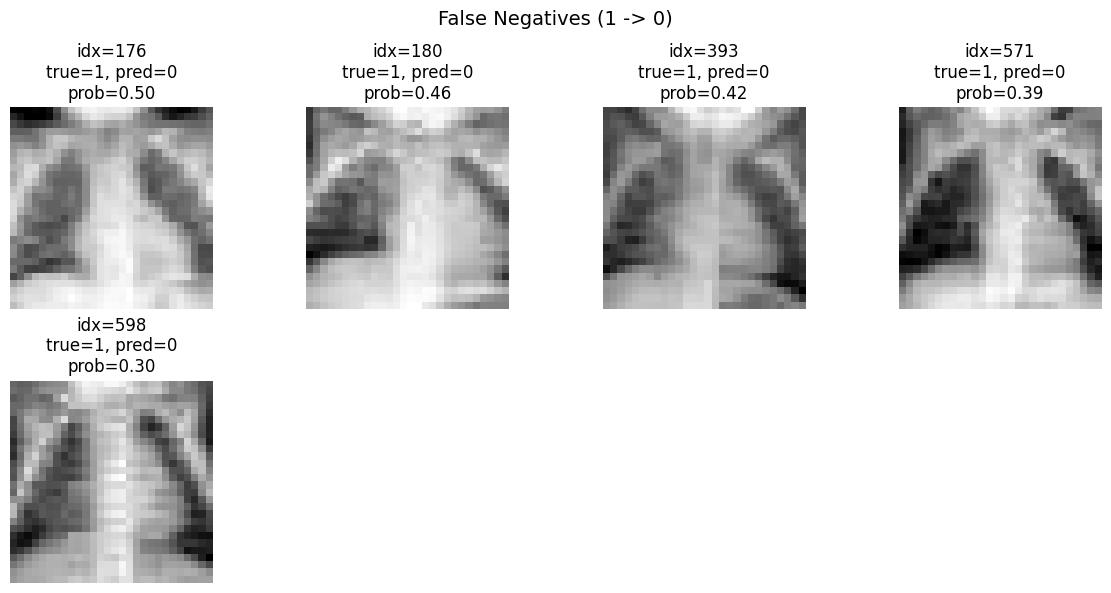

In [26]:
# Helper: unnormalize image for display (we used Normalize(mean=0.5, std=0.5))
def unnormalize(img_tensor):
    # img_tensor shape: [1, 28, 28]
    return img_tensor * 0.5 + 0.5

def show_examples(indices, title, max_show=12):
    n = min(len(indices), max_show)
    if n == 0:
        print(f"No examples to show for: {title}")
        return

    cols = 4
    rows = int(np.ceil(n / cols))

    plt.figure(figsize=(12, 3*rows))
    for i in range(n):
        idx = int(indices[i])
        x, y = test_ds[idx]           # x is normalized tensor
        x_disp = unnormalize(x).squeeze(0).numpy()

        p = float(test_probs[idx])
        pred = int(test_pred[idx])
        true = int(test_y[idx])

        plt.subplot(rows, cols, i+1)
        plt.imshow(x_disp, cmap="gray")
        plt.axis("off")
        plt.title(f"idx={idx}\ntrue={true}, pred={pred}\nprob={p:.2f}")

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

print("Showing False Positives (Normal predicted as Pneumonia):")
show_examples(fp_idx, "False Positives (0 -> 1)", max_show=12)

print("\nShowing False Negatives (Pneumonia predicted as Normal):")
show_examples(fn_idx, "False Negatives (1 -> 0)", max_show=12)


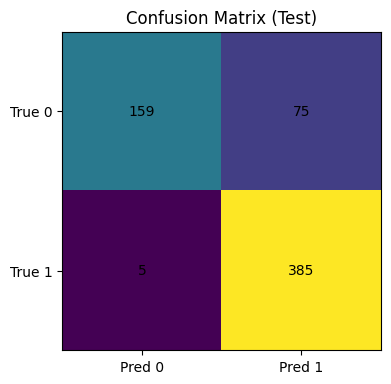

Saved: outputs/figures/confusion_matrix.png


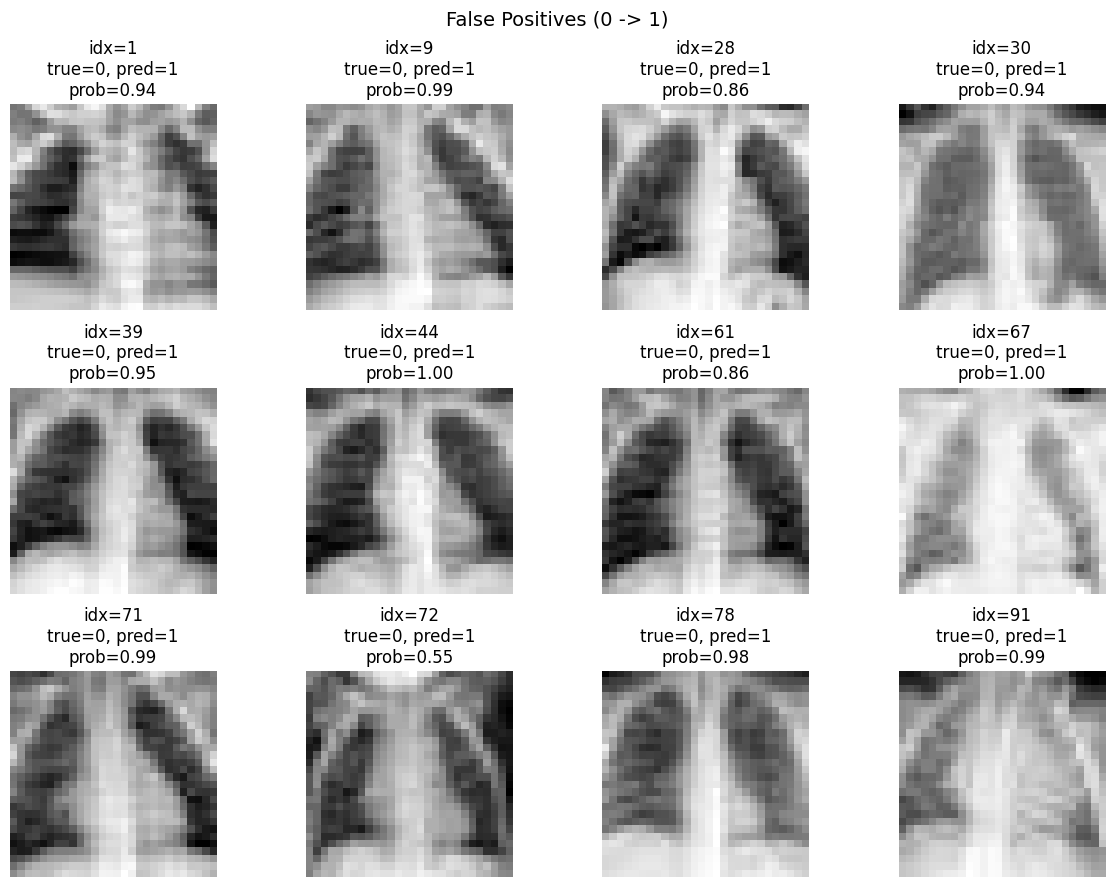

Saved: outputs/figures/false_positives.png


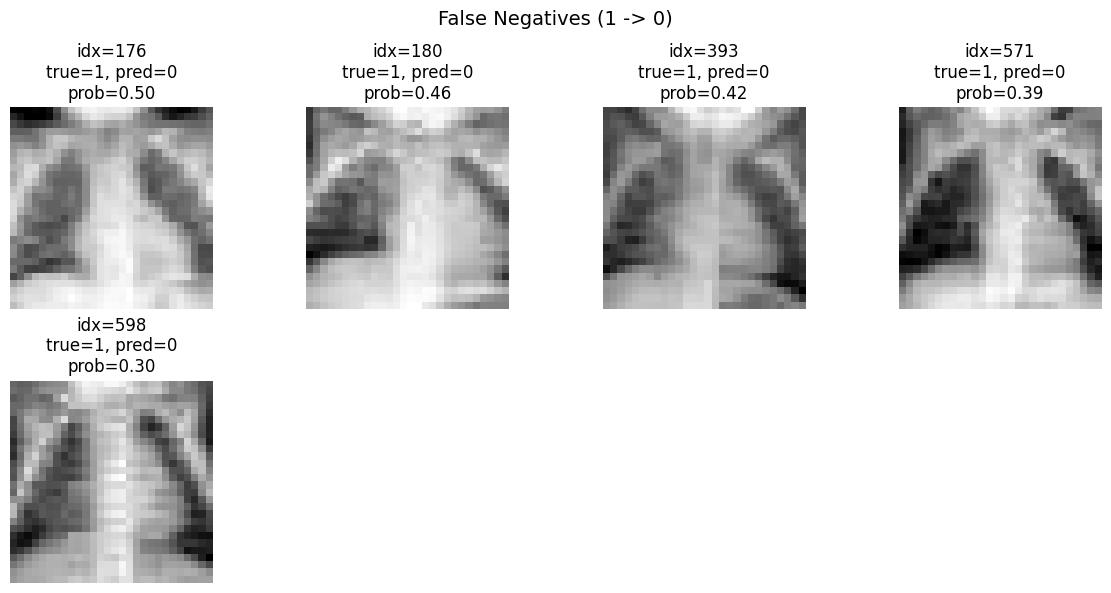

Saved: outputs/figures/false_negatives.png


In [27]:
import os
os.makedirs("outputs/figures", exist_ok=True)

# 1) Save confusion matrix heatmap
cm = confusion_matrix(test_y, test_pred)
plt.figure(figsize=(4,4))
plt.imshow(cm)
plt.title("Confusion Matrix (Test)")
plt.xticks([0,1], ["Pred 0", "Pred 1"])
plt.yticks([0,1], ["True 0", "True 1"])
for (i,j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.tight_layout()
plt.savefig("outputs/figures/confusion_matrix.png", dpi=200)
plt.show()
print("Saved: outputs/figures/confusion_matrix.png")

# 2) Save FP grid
def save_grid(indices, filename, title, max_show=12):
    n = min(len(indices), max_show)
    if n == 0:
        print(f"No examples to save for: {title}")
        return

    cols = 4
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(12, 3*rows))
    for i in range(n):
        idx = int(indices[i])
        x, y = test_ds[idx]
        x_disp = unnormalize(x).squeeze(0).numpy()

        p = float(test_probs[idx])
        pred = int(test_pred[idx])
        true = int(test_y[idx])

        plt.subplot(rows, cols, i+1)
        plt.imshow(x_disp, cmap="gray")
        plt.axis("off")
        plt.title(f"idx={idx}\ntrue={true}, pred={pred}\nprob={p:.2f}")

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.savefig(filename, dpi=200)
    plt.show()
    print("Saved:", filename)

save_grid(fp_idx, "outputs/figures/false_positives.png", "False Positives (0 -> 1)", max_show=12)
save_grid(fn_idx, "outputs/figures/false_negatives.png", "False Negatives (1 -> 0)", max_show=12)
